In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

서울,인천,수원,~ 여주 주간
1. data frame
- 도시, 날짜 멀티인덱스
- 날씨, 최저, 최고
2. EDA 데이터분석

# cralwling

### 지원씨의 더 나은 크롤링 방식

In [3]:
from bs4 import BeautifulSoup
import urllib.request as MyURL

#서울 / 경기도 RSS 
japi = 'http://www.kma.go.kr/weather/forecast/mid-term-rss3.jsp?stnId=109'

response = MyURL.urlopen(japi)
weather = BeautifulSoup(response, "html.parser") #html5lib 사용하면 종료태그 닫히지 않을 수 있는 부분 개선
                                                    #xml은 딱히 상관 없으나 html 사용 시 추천

wdata = []
for location in weather.select('location'):          #html 경우 findAll 대신 select('선택자')
    for data in location.select('data'):
        wdata.append({'도시':location.city.string,
                     '날짜':data.tmef.string,
                     '날씨':data.wf.string,
                     '최저':data.tmn.string,
                     '최고':data.tmx.string} )

wdf = pd.DataFrame( wdata )
wdf

,도시,날짜,날씨,최저,최고
0,서울,2022-01-15 00:00,구름많음,-5,4
1,서울,2022-01-15 12:00,흐림,-5,4
2,서울,2022-01-16 00:00,구름많고 비/눈,-2,1
3,서울,2022-01-16 12:00,맑음,-2,1
4,서울,2022-01-17 00:00,맑음,-9,-1
...,...,...,...,...,...
450,여주,2022-01-19 00:00,맑음,-7,1
451,여주,2022-01-19 12:00,맑음,-7,1
452,여주,2022-01-20 00:00,맑음,-11,0
453,여주,2022-01-21 00:00,맑음,-9,1


### 2번째 방식

In [6]:
temp1 = []
def parse(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    allweek = soup.find_all('location')
    for location_df in allweek:
        time = [location_df.find('city').text +' - ' + a.text for a in location_df.find_all('tmef')]      
        low_tem = [a.text for a in location_df.find_all('tmn')]
        max_tem = [a.text for a in location_df.find_all('tmx')]
        wf = [a.text for a in location_df.find_all('wf')]
        temp = [time, low_tem, max_tem, wf]
        
        seper_df = pd.DataFrame(temp)
        temp1.append(seper_df)
    return temp1

In [7]:
all_list = parse('https://www.kma.go.kr/weather/forecast/mid-term-rss3.jsp?stnId=109')
df = pd.concat(all_list, axis=1).T

In [8]:
df.columns = ["city", 'low_tem', "max_tem", "weather"]

In [9]:
df.index = pd.to_datetime(df.index)

# EDA

### 1. 도시와 날짜를 인덱스로 설정하시요

In [10]:
df[['city_name', 'time']] = df['city'].str.split(' - ', 1, expand=True)

In [11]:
df = df.set_index(['city_name','time']) 

### 2. 도시별 최고, 최저기온 평균을 구하시요.구름많고 비/눈

In [12]:
df.low_tem = pd.to_numeric(df.low_tem)
df.max_tem = pd.to_numeric(df.max_tem)

In [13]:
df.drop(['city'], axis = True, inplace = True)

### 도시별 최고, 최저기온 평균을 구하시요.

In [14]:
df.groupby(['city_name'], sort=False).mean().sort_values(by='low_tem')

,low_tem,max_tem
city_name,,
연천,-11.769231,-1.846154
가평,-11.307692,0.615385
파주,-10.076923,0.000000
양주,-10.000000,0.000000
포천,-9.846154,0.076923
남양주,-9.076923,-0.076923
의정부,-8.769231,0.000000
동두천,-8.769231,0.769231
광주,-8.538462,0.615385


### '눈'이 오는 도시 날짜 날씨를 구하시요

In [15]:
df[ df['weather'].str.contains('눈') ][['weather']]

,,weather
city_name,time,
서울,2022-01-16 00:00,구름많고 비/눈
인천,2022-01-16 00:00,구름많고 비/눈
수원,2022-01-16 00:00,구름많고 비/눈
파주,2022-01-16 00:00,구름많고 비/눈
이천,2022-01-16 00:00,구름많고 비/눈
평택,2022-01-16 00:00,구름많고 비/눈
백령도,2022-01-16 00:00,구름많고 비/눈
과천,2022-01-16 00:00,구름많고 비/눈
광명,2022-01-16 00:00,구름많고 비/눈


### 최저기온이 가장 낮은 도시, 날짜, 최고기온을 구하시요

In [16]:
df.nsmallest(1, 'low_tem', keep='all')[['max_tem']]

max_tem
city_name time                     
연천        2022-01-17 00:00       -4
          2022-01-17 12:00       -4
          2022-01-18 00:00       -2
          2022-01-18 12:00       -2

 ### 서울지역의 날짜별 최고 최저기온을 바차트로 그리시요

In [22]:
seoul_tem = df.loc['서울']
seoul_tem.groupby(seoul_tem.index.day).mean().plot(kind='bar')

AttributeError: 'MultiIndex' object has no attribute 'day'

###  여주 지역 최저기온이 -10 도 이하인 데이터를 구하시요

In [24]:
yeojoo= df.loc['여주']
# yeojoo[ yeojoo['low_tem'] <= -10 ]
yeojoo.query( 'low_tem <= -10' )

,low_tem,max_tem,weather
time,,,
2022-01-17 00:00,-10,-1,맑음
2022-01-17 12:00,-10,-1,맑음
2022-01-18 00:00,-10,-1,맑음
2022-01-18 12:00,-10,-1,맑음
2022-01-20 00:00,-11,0,맑음


### 여주지역 전체 최고기온 중 최고기온이 0 도 이상이 차지하는 비율

In [25]:
result = len( yeojoo.query( 'max_tem >= 0' ) ) / len(yeojoo)
print( f'{result*100:.2f}%' )

69.23%


### 일교차 컬럼을 추가하고 <br> 최고기온과 최저기온의 차이가 가장높은 도시,날짜,최저,최고,일교차를 구하시요

In [26]:
df['diurnal_temp'] = df.max_tem - df.low_tem

In [27]:
df.nlargest(1, 'diurnal_temp', keep='all')

low_tem  max_tem weather  diurnal_temp
city_name time                                                    
포천        2022-01-18 00:00      -13        1      맑음            14
          2022-01-18 12:00      -13        1      맑음            14
가평        2022-01-18 00:00      -14        0      맑음            14
          2022-01-18 12:00      -14        0      맑음            14
          2022-01-20 00:00      -13        1      맑음            14
          2022-01-22 00:00      -12        2    구름많음            14

## arima prediction

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from warnings import filterwarnings
filterwarnings("ignore")

In [65]:
seoul = df.loc['서울']
seoul.index = pd.to_datetime(seoul.index)
seoul.index

DatetimeIndex(['2022-01-14 00:00:00', '2022-01-14 12:00:00',
               '2022-01-15 00:00:00', '2022-01-15 12:00:00',
               '2022-01-16 00:00:00', '2022-01-16 12:00:00',
               '2022-01-17 00:00:00', '2022-01-17 12:00:00',
               '2022-01-18 00:00:00', '2022-01-18 12:00:00',
               '2022-01-19 00:00:00', '2022-01-20 00:00:00',
               '2022-01-21 00:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)

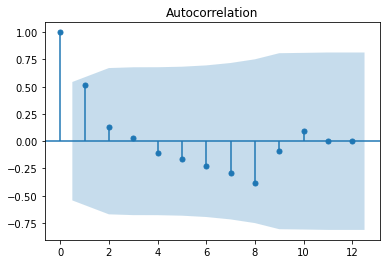

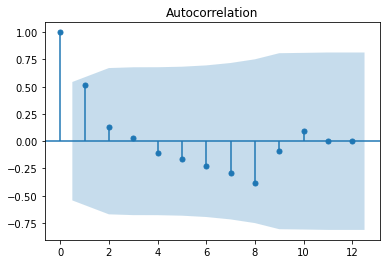

In [66]:
plot_acf(seoul['max_tem'])

In [67]:
result = adfuller(seoul['max_tem'])
print(result[0]) # 적을 수록 귀무가설을 기각시킬 가능성이 큼.
print(result[1]) # pvalue

-1.6944422239425094
0.43397826137744033


In [68]:
def arima_aic_check(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p:{p} d:{d} q:{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [69]:
arima_aic_check(seoul['max_tem'], [3,3,3])

,order,AIC
1,p:0 d:0 q:1,48.230771
5,p:0 d:1 q:2,48.509234
3,p:0 d:1 q:0,48.608663
13,p:2 d:1 q:0,50.095544
2,p:0 d:0 q:2,50.175285
7,p:0 d:2 q:1,50.182645
9,p:1 d:0 q:0,50.311033
4,p:0 d:1 q:1,50.606532
10,p:1 d:1 q:0,50.608184
12,p:2 d:0 q:0,51.320080


In [70]:
order = (0,1,2)
model = ARIMA(seoul['max_tem'].astype('float32'), order)

rfit = model.fit()
rfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.max_tem   No. Observations:                   12
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 -20.255
Method:                       css-mle   S.D. of innovations              1.113
Date:                Tue, 11 Jan 2022   AIC                             48.509
Time:                        19:48:30   BIC                             50.449
Sample:                             1   HQIC                            47.791
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1429      0.149     -0.961      0.337      -0.434       0.149
ma.L1.D.max_tem  1.505e-08        nan        nan        nan         nan         nan
ma.L2.D.max_tem    -1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0000           +0.0000j            1.0000            0.5000
MA.2            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

##  3가지 시도
### 실패한 방법 1

In [72]:
preds = rfit.predict('2022-01-22 00:00', '2022-01-28 00:00', typ = 'levels', )

KeyError: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'

### 시도2
- 12:00으로 되어있는 시간이 혼선을 주는 것 같아서, 없앰.
- 또한 실질적으로 12:00과 00:00 데이터가 동일함.

In [74]:
seoul.index = seoul.index.to_period('d')

In [49]:
index = seoul.index

In [51]:
new = seoul[~index.duplicated(keep='first')]

In [53]:
# new는 12:00를 제외한 데이터
new

,low_tem,max_tem,weather,diurnal_temp
time,,,,
2022-01-14,-11,1,맑음,12
2022-01-15,-5,4,구름많음,9
2022-01-16,-3,1,구름많고 비/눈,4
2022-01-17,-8,0,맑음,8
2022-01-18,-7,0,맑음,7
2022-01-19,-7,-1,맑음,6
2022-01-20,-9,-1,맑음,8
2022-01-21,-6,2,맑음,8


In [78]:
result = adfuller(new['max_tem'])
print(result[0]) # 적을 수록 귀무가설을 기각시킬 가능성이 큼.
print(result[1]) # pvalue

-1.6781728517429393
0.44239210939672546


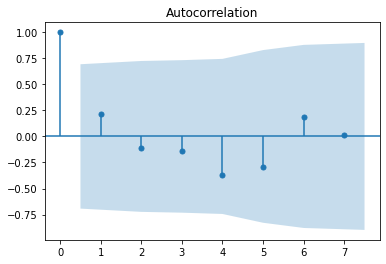

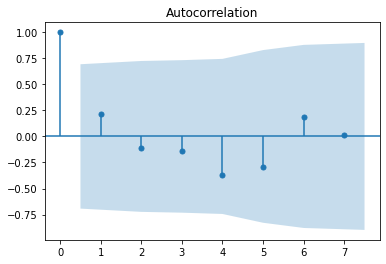

In [79]:
plot_acf(new['max_tem'])

In [80]:
arima_aic_check(new['max_tem'], [3,3,3])

,order,AIC
4,p:0 d:1 q:1,33.762511
3,p:0 d:1 q:0,33.780271
0,p:0 d:0 q:0,33.830800
6,p:0 d:2 q:0,33.984168
7,p:0 d:2 q:1,34.123296
9,p:1 d:1 q:0,35.163416
1,p:0 d:0 q:1,35.274118
10,p:1 d:2 q:0,35.300579
8,p:1 d:0 q:0,35.462482
13,p:2 d:2 q:0,35.474911


In [81]:
order = (0,1,1)
model = ARIMA(seoul['max_tem'], order)

rfit = model.fit()
rfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.max_tem   No. Observations:                   12
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -22.303
Method:                       css-mle   S.D. of innovations              1.552
Date:                Tue, 11 Jan 2022   AIC                             50.607
Time:                        19:56:04   BIC                             52.061
Sample:                    01-14-2022   HQIC                            50.068
                         - 01-21-2022                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0906      0.486      0.187      0.852      -0.861       1.042
ma.L1.D.max_tem     0.0321      0.695      0.046      0.963      -1.330       1.394
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1          -31.1552           +0.0000j           31.1552            0.5000
-----------------------------------------------------------------------------
"""

In [84]:
preds = rfit.predict('2022-01-22', '2022-01-28', typ = 'levels')

In [85]:
preds 

2022-01-21    0.088843
2022-01-22    0.087776
2022-01-23    0.087810
2022-01-24   -0.944288
2022-01-25   -0.911160
2022-01-26    2.184068
2022-01-27    2.274696
2022-01-28    2.365324
Freq: D, dtype: float64

### 3번째 시도(by 동환)

In [103]:
rfit.predict(8,19 , typ='levels')

2022-01-21    0.088843
2022-01-22    0.087776
2022-01-23    0.087810
2022-01-24   -0.944288
2022-01-25   -0.911160
2022-01-26    2.184068
2022-01-27    2.274696
2022-01-28    2.365324
2022-01-29    2.455952
2022-01-30    2.546580
2022-01-31    2.637208
2022-02-01    2.727836
Freq: D, dtype: float64